Jonas Macken - z5208799

First, lets import all the librarys, packages, modules, subpackages, submodules, functions, and classes we will need.

In [1]:
import matplotlib.pyplot as plt # Used for visualizations 
import numpy as np # Used for operations on arrays
import pandas as pd # Used for data manipulation and analysis
import tensorflow as tf # Library to build ML models
from scipy.stats import pearsonr # Used to assist with feature selection
from tensorflow.keras.layers import Dense, Input, Dropout # Used to create connected layers in models and do regularization
from tensorflow.keras.models import Sequential # Used to create a model with a sequence of layers
from tensorflow.keras.optimizers import Adam # Used to trial different learnig rates
from tensorflow.keras.regularizers import l2 # Used to stop model from overfitting
from sklearn.preprocessing import StandardScaler # Used to scale input features
from sklearn.model_selection import train_test_split, KFold # Used to split dataset into training and testing / validation sets, k-fold to validate performance with diff splits
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay # Used to generate results for classification tasks

In [2]:
filepath = 'AirQualityUCI _ Students.xlsx'
data = pd.read_excel(filepath)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


First, we note that the data is sequential, i.e., the earliest measurement is at the top of the dataset and the last measurement is at the bottom. Because of this, we should randomly shuffle our data before we later split it up into training and validation sets. If we don't shuffle the data, the data in our training set may differ significantly from the data in our validation set, and our resulting model will be less accurate. For example, if the training set consists of all the measurements taken in winter, while our validation set consists of all the measurements taken in summer, our model will learn based on winter measurements and may not be reliable for testing on datasets with summer measurements. So lets shuffle and observe the shuffled dataset.

In [3]:
shuffled_data = data.sample(frac = 1).reset_index(drop = True) # Randomly samples all of the rows resulting in a shuffled dataset, and then resets the indices so indices of shuffled dataset is still in order
shuffled_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-10-05,06:00:00,-200.0,990.25,-200,7.754410,889.00,-200.0,762.75,-200.0,1449.50,951.50,17.375,69.725,1.371437
1,2005-02-20,19:00:00,1.1,1016.00,-200,2.912492,646.50,154.4,906.00,118.5,997.00,648.75,7.075,62.650,0.634106
2,2004-06-08,21:00:00,2.8,1144.50,-200,15.677917,1169.75,157.0,750.75,123.0,1894.00,1376.00,26.700,35.450,1.223293
3,2004-09-28,11:00:00,3.4,1249.75,-200,19.397099,1279.50,550.0,618.00,181.0,1662.50,2178.00,24.450,29.800,0.900797
4,2004-08-19,20:00:00,1.7,1100.50,-200,7.410351,874.50,65.0,722.25,68.0,1747.75,927.25,31.625,43.550,1.994374


Lets drop the date and time features now too, since we don't know what dates our model will be used for, and a range of values between 2004 and 2005 will likely not be useful as a feature to predict things happening in 2024, for example.

In [4]:
shuffled_data = shuffled_data.iloc[:,2:]

Now lets make two copies of this dataset; 1 for the classification task, and one for the regression task. This is important as different features will be used for each task.

For the classification dataset, we want to drop all the samples that didn't provide a CO(GT) value. This is because CO(GT) values are what make up our target value, so if a data point doesn't contain a target value, it won't be very useful in teaching the model anything.

Similarly for the regression dataset, we want to drop all the samples that didn't provide an NOx(GT) value, as these data points don't have a target so don't tell us anything.

In [5]:
# Create the classification dataset
count_minus_200 = (shuffled_data['CO(GT)'] == -200).sum()
print(f'Number of rows with missing CO(GT) value in the original dataset: {count_minus_200}')
print(f'Size of original dataset: {shuffled_data.shape[0]}')

classification_data = shuffled_data.drop(shuffled_data[shuffled_data['CO(GT)'] == -200].index) # Create a new dataframe that is same as original dataset but drops all rows where CO(GT) is missing
classification_data.reset_index(drop=True, inplace=True) # Resets index so rows are numbered correctly

print(f'Size of dataset once rows with missing CO(GT) values have been removed: {classification_data.shape[0]}') # This value should be equal to (size of original dataset - num rows with missing CO(GT))

count_minus_200_in_classification_data = (classification_data['CO(GT)'] == -200).sum() # Count the number of missing CO(GT)s in the refined dataset 
print(f'Number of rows with missing CO(GT) value in the revised dataset: {count_minus_200_in_classification_data}') # This should be 0

print('\n')

# Create the regression dataset
count_minus_200 = (shuffled_data['NOx(GT)'] == -200).sum()
print(f'Number of rows with missing NOx(GT) value in the original dataset: {count_minus_200}')
print(f'Size of original dataset: {shuffled_data.shape[0]}')

regression_data = shuffled_data.drop(shuffled_data[shuffled_data['NOx(GT)'] == -200].index) # Create a new dataframe that is same as original dataset but drops all rows where NOx(GT) is missing
regression_data.reset_index(drop=True, inplace=True) # Resets index so rows are numbered correctly

print(f'Size of dataset once rows with missing NOx(GT) values have been removed: {regression_data.shape[0]}') # This value should be equal to (size of original dataset - num rows with missing NOx(GT))

count_minus_200_in_regression_data = (regression_data['NOx(GT)'] == -200).sum() # Count the number of missing NOx(GT)s in the refined dataset 
print(f'Number of rows with missing NOx(GT) value in the revised dataset: {count_minus_200_in_regression_data}') # This should be 0

Number of rows with missing CO(GT) value in the original dataset: 1585
Size of original dataset: 8358
Size of dataset once rows with missing CO(GT) values have been removed: 6773
Number of rows with missing CO(GT) value in the revised dataset: 0


Number of rows with missing NOx(GT) value in the original dataset: 1573
Size of original dataset: 8358
Size of dataset once rows with missing NOx(GT) values have been removed: 6785
Number of rows with missing NOx(GT) value in the revised dataset: 0


Lets now calculate the mean of the CO(GT) column as a variable that we will later use for the classification task.

In [6]:
CO_GT_Mean = classification_data['CO(GT)'].mean() # Calculates the mean of the CO(GT) column in our classification dataset
print(CO_GT_Mean)

2.1469511294847186


To visualize the classification dataset, we can plot a histogram for each variable, showing the spread of the values.

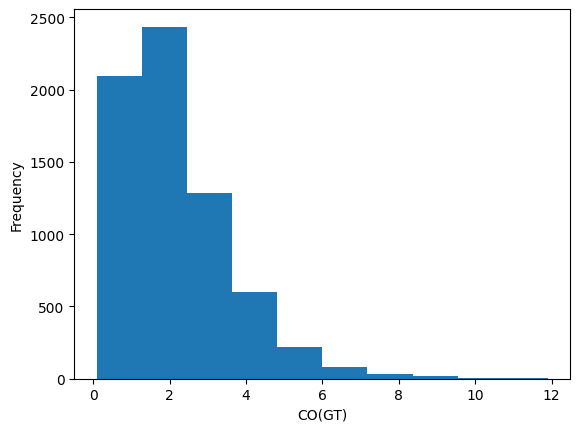

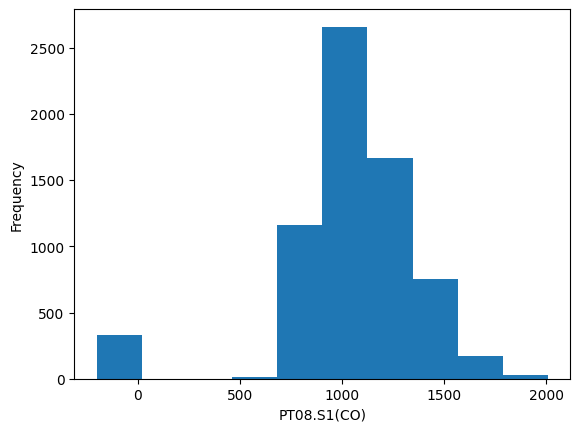

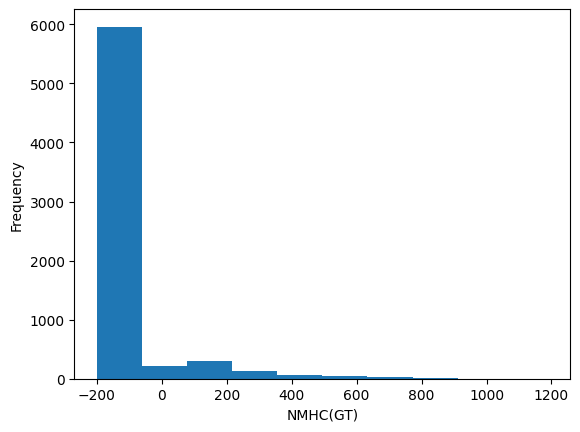

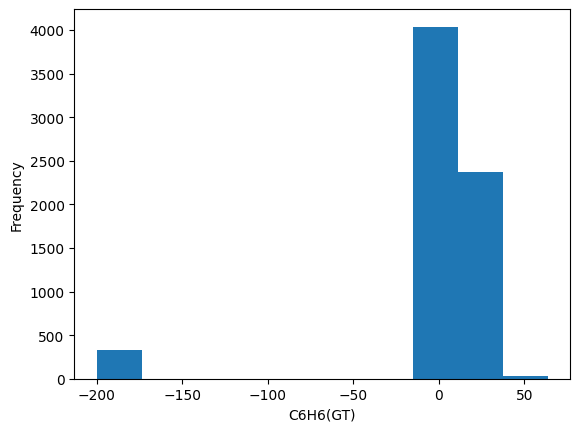

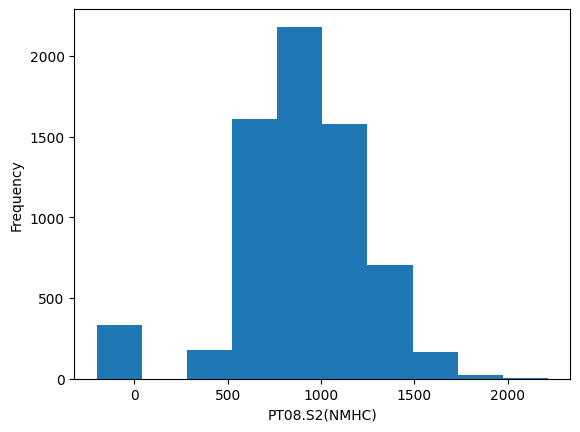

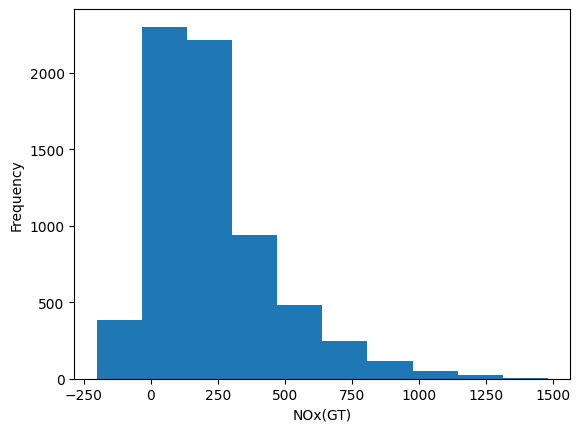

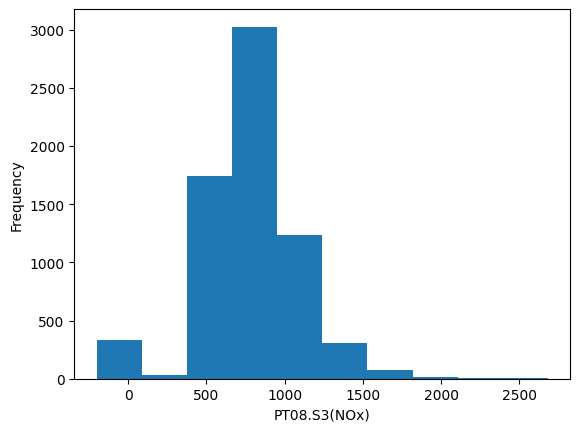

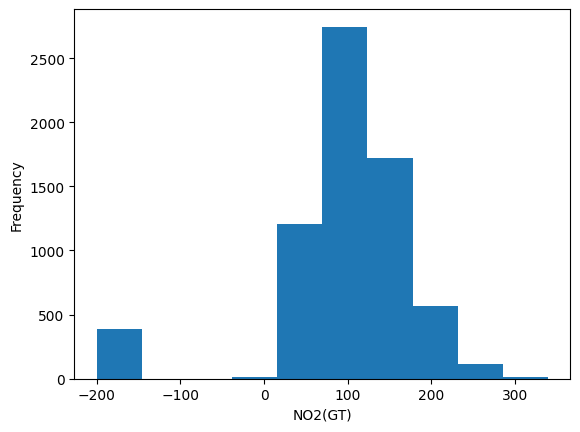

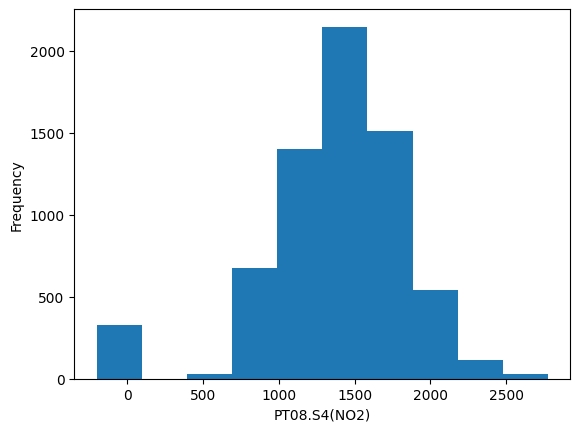

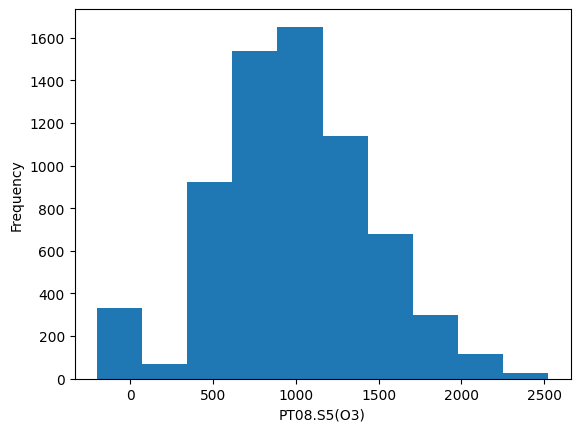

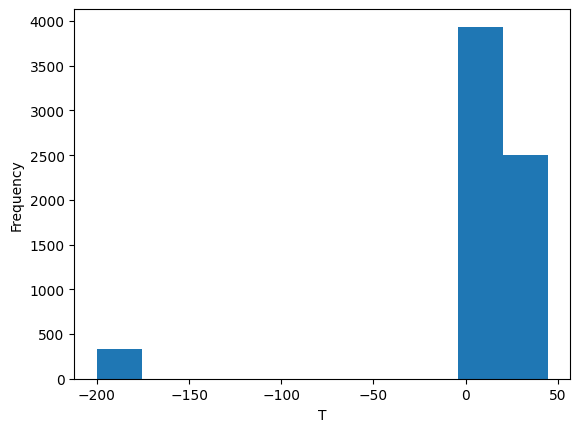

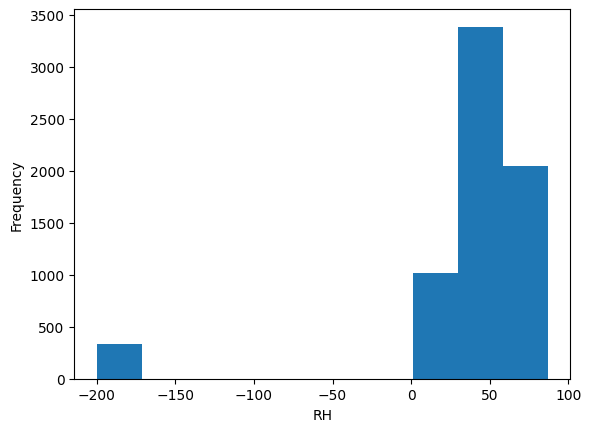

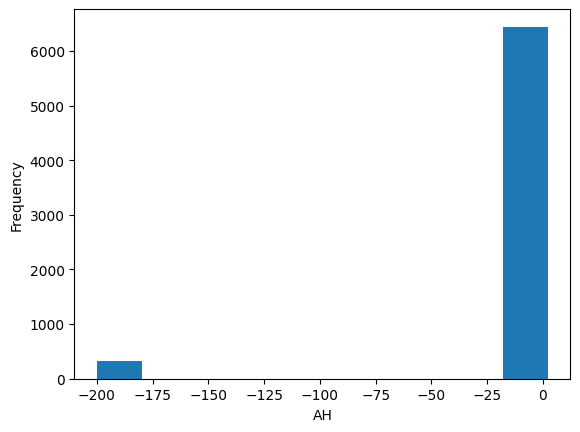

In [7]:
for column in classification_data.columns:
    plt.figure() # Create a figure
    plt.hist(classification_data[column]) # Histogram of the data in the column, showing the frequency of ranges of values
    plt.xlabel(column) # X label is the name of the column
    plt.ylabel('Frequency') # Y label is frequency of each range of values
    plt.show() # Show the plot

Looking at the plots, we see that many -200 values have been recorded for each variable. Lets replace these -200 values with NaN values and then replace them with the means of their respective columns.


In [8]:
classification_data.replace(-200, np.nan, inplace = True)  # Replaces all -200 values with NaN values, and does so in place without needing to create a new table
classification_data.fillna(classification_data.mean(), inplace = True) # Replaces all NaN values with the mean of their respective columns, and does so in place without needing to create a new table

Now we can begin the classification task.

First, lets create a new dataframe with a single column called "Label", and set it to 0 or 1 for each row depending on whether the CO(GT) value for that row in the classification dataset reaches the threshold (1 if greater than or equal to the mean, 0 otherwise).

In [9]:
classification_labels = pd.DataFrame()
classification_labels['Label'] = (classification_data['CO(GT)'] >= CO_GT_Mean).astype(int) # Fills each row with a 1 if the CO(GT) value in the corresponding row of our dataset is greater than or equal to the mean, or 0 otherwise                         

Lets now do some feature selection for our classification model.

To get an idea of how each variable correlates with 'CO(GT)' we can plot each of them individually against 'CO(GT)' and calculate a correlation coefficient.





Correlation coefficient between PT08.S1(CO) and CO(GT): 0.8452832637702146


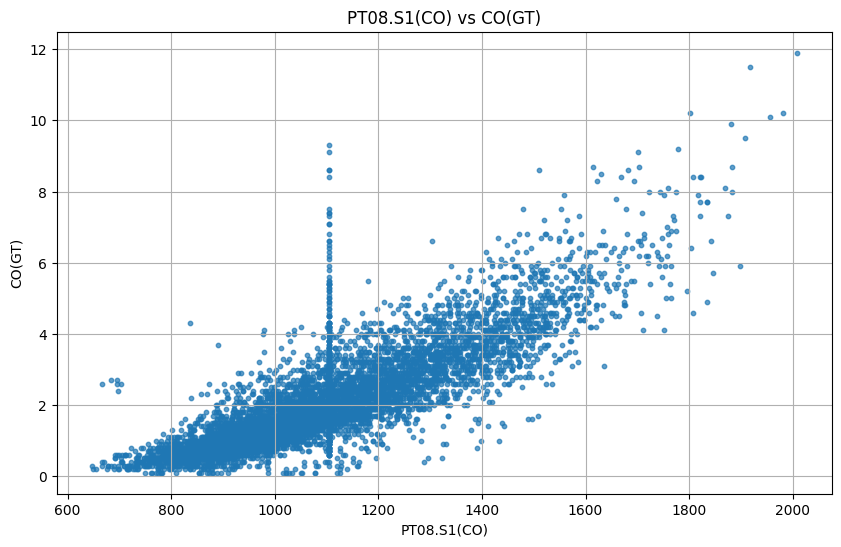



Correlation coefficient between NMHC(GT) and CO(GT): 0.2877241231015749


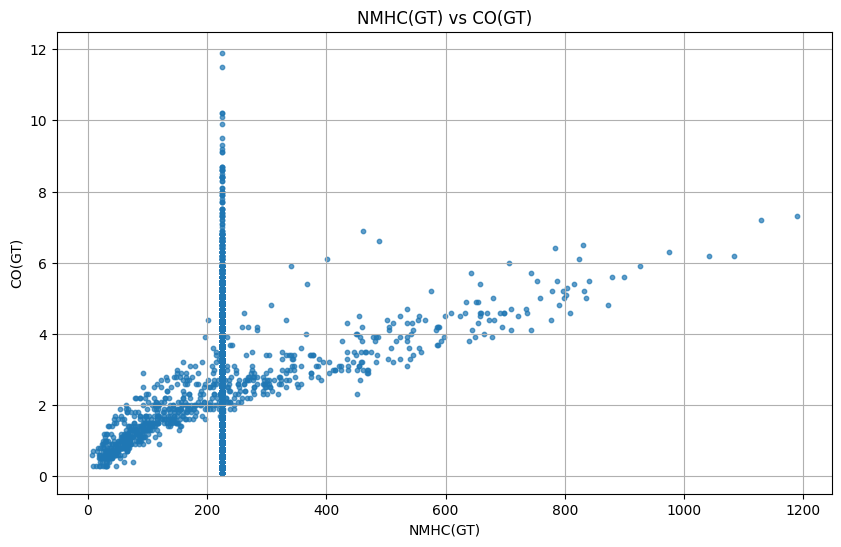



Correlation coefficient between C6H6(GT) and CO(GT): 0.8922338366592713


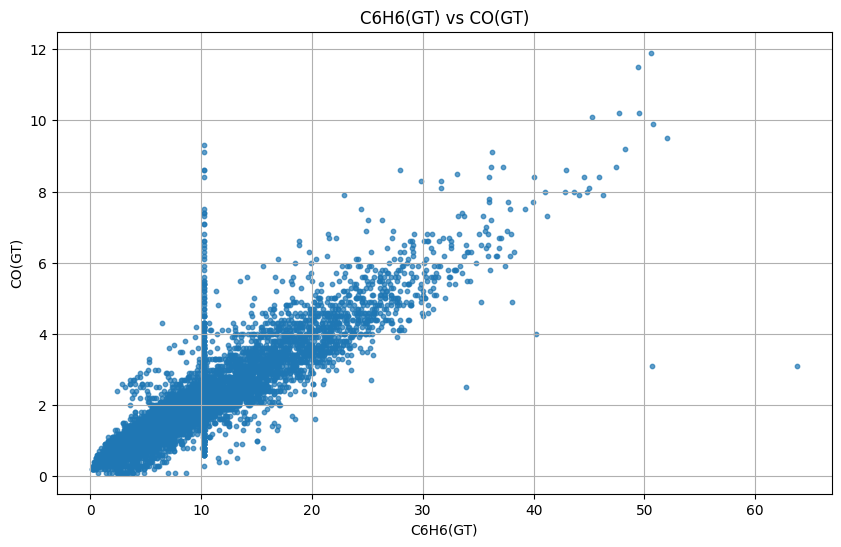



Correlation coefficient between PT08.S2(NMHC) and CO(GT): 0.8778077297392595


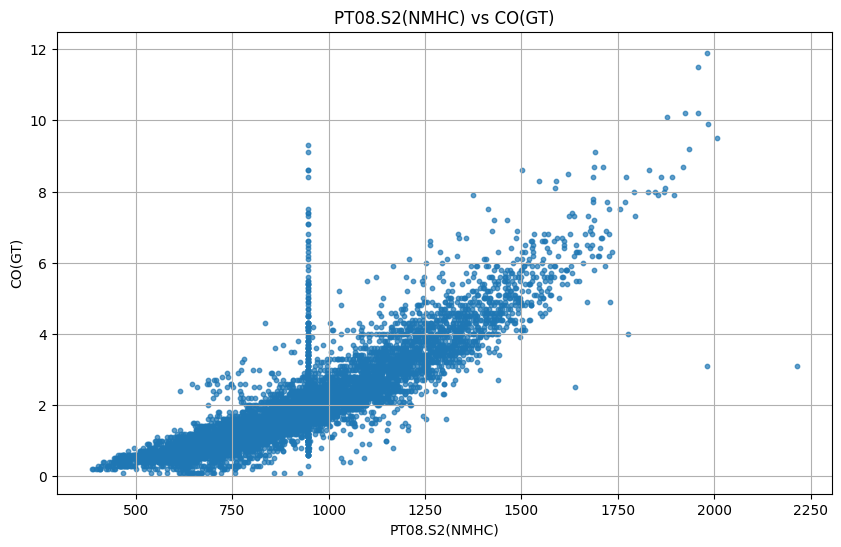



Correlation coefficient between NOx(GT) and CO(GT): 0.7764651459110068


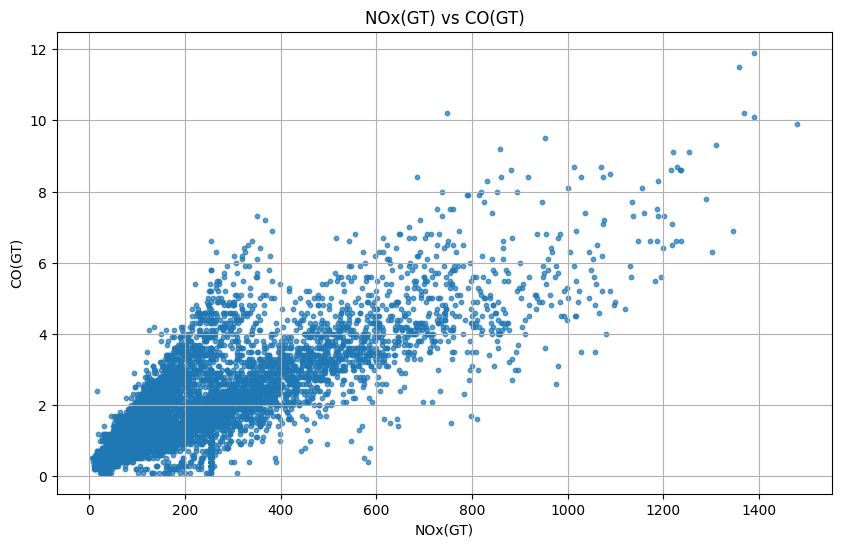



Correlation coefficient between PT08.S3(NOx) and CO(GT): -0.6922848229978573


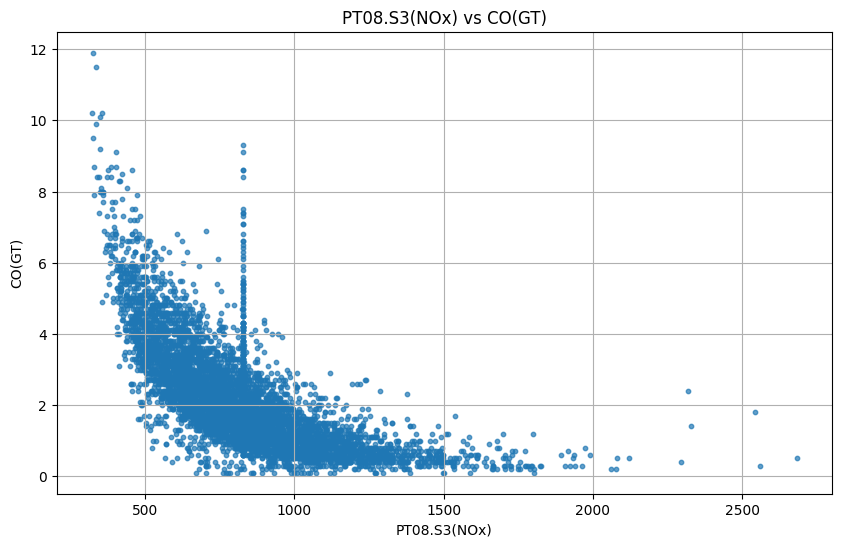



Correlation coefficient between NO2(GT) and CO(GT): 0.666687042434414


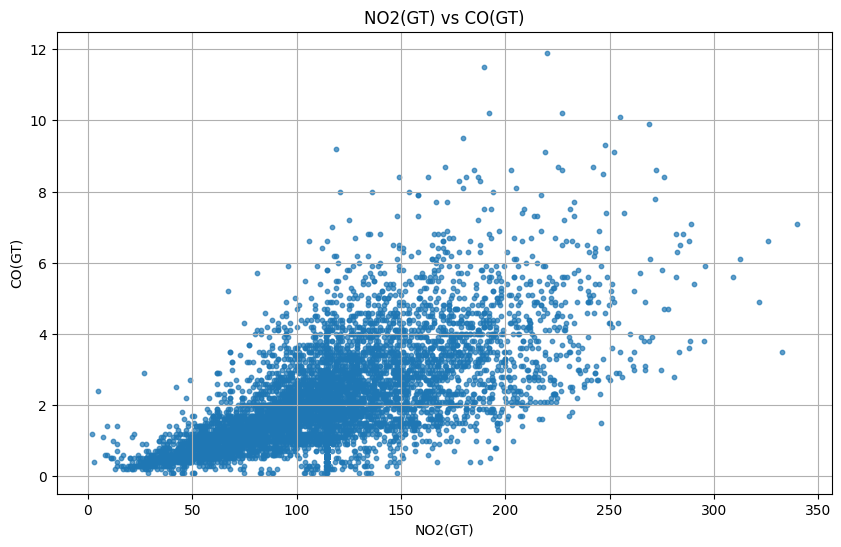



Correlation coefficient between PT08.S4(NO2) and CO(GT): 0.5911286336982483


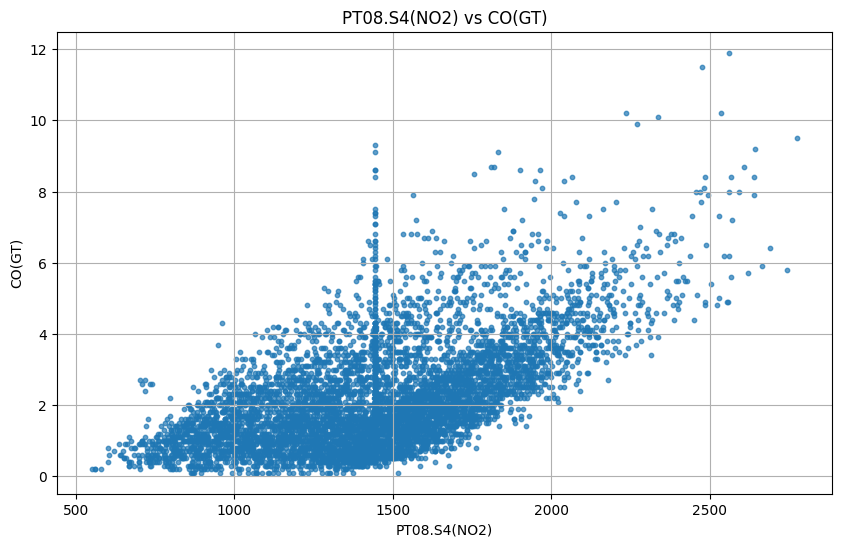



Correlation coefficient between PT08.S5(O3) and CO(GT): 0.8198749542307129


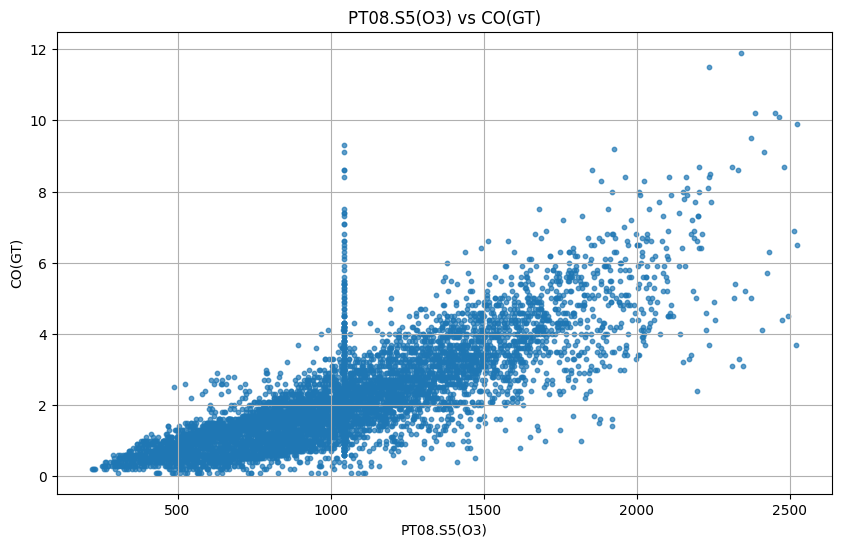



Correlation coefficient between T and CO(GT): 0.01763999419426839


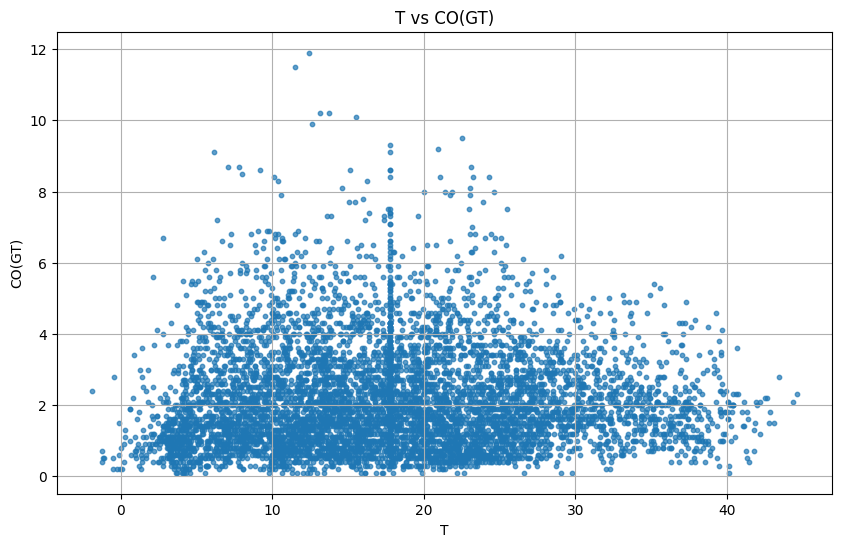



Correlation coefficient between RH and CO(GT): 0.04502969023184067


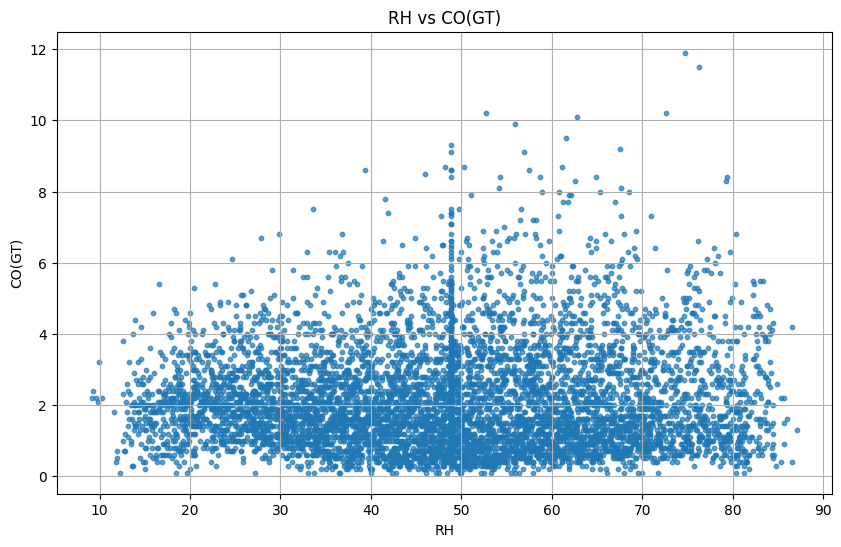



Correlation coefficient between AH and CO(GT): 0.04233428493006261


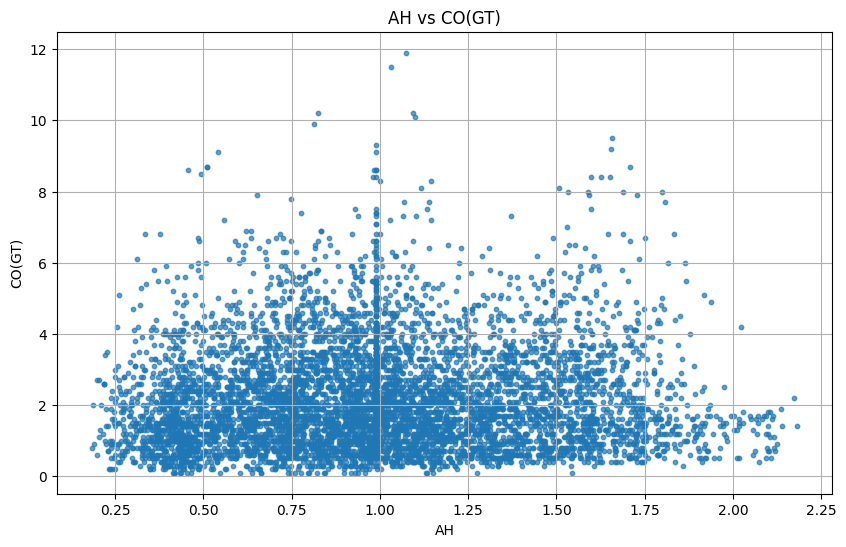

In [10]:
Y_plot = classification_data['CO(GT)'] # We will be plotting each variable independently against CO(GT) values

correlation_coefficients = {}

for column in classification_data.columns:
    print('\n')
    if column == 'CO(GT)':
        continue # We don't want to plot CO(GT) against itself
        
    X_plot = classification_data[column]
    correlation_coefficient, p_value = pearsonr(X_plot, Y_plot) # Calculate the correlation coefficient
    correlation_coefficients[column] = correlation_coefficient # Add the correlation coefficient to dictionary
    print(f'Correlation coefficient between {column} and CO(GT): {correlation_coefficient}') # Values closer to 1 or -1 indicate a strong relationship
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_plot, Y_plot, s=10, alpha=0.7)
    plt.title(f'{column} vs CO(GT)')
    plt.xlabel(column)
    plt.ylabel('CO(GT)')
    plt.grid(True)
    plt.show()

In [11]:
for key in correlation_coefficients:
    print(f'{key}: {correlation_coefficients[key]:.2f}')

PT08.S1(CO): 0.85
NMHC(GT): 0.29
C6H6(GT): 0.89
PT08.S2(NMHC): 0.88
NOx(GT): 0.78
PT08.S3(NOx): -0.69
NO2(GT): 0.67
PT08.S4(NO2): 0.59
PT08.S5(O3): 0.82
T: 0.02
RH: 0.05
AH: 0.04


Looking at the plots and correlation coefficients, we can see that T, RH, and AH have particularly low linear correlations with CO(GT). However, these features could still be useful in combination with other features, or if not, our model will be large enough that can ignore them, so there's no harm in leaving these features in our model.

So lets keep all the features listed above in our model.

Before we start building and training the model, we should scale the data so that the range of values for each feature is similar. This is to ensure that some features are not considered more than others in the model and that the model can converge quickly and smoothly. For example, consider our 'PST08.S1(CO)' feature and our 'C6H6(GT)' feature. The 'PT08.S1(CO)' values are larger by a factor of around 100. This feature will therefore be contributing to the calculated loss much more than the 'CO(GT)' feature, and small fluctuations in parameters that are multiplied by this feature will cause large changes to the calculated loss.

Before scaling the data, we need to split it up into training, validation, and testing sets. If we scale the entire dataset before splitting, the scaling parameters (e.g. mean, variance, etc.) will be influenced by the entire dataset, meaning that information from the validation and testing set is indirectly being used in the training process. This can cause deceptively successful results and generalization on true unseen data would likely be worse than expected.

Let's use sklean's train_test_split function to split the dataset into training, validation, and testing subsets. Based on trial and error, an 80% training, 10% validation, and 10% testing split seems effective. After trialing both normalization and standardization of the data, standardization appears to be performing better. This may be due to many of our features being normally distributed. Whatever the cause, lets stick with standardization.

In [12]:
X = classification_data.drop(columns = ['CO(GT)']) # Include all features except for 'CO(GT)' (the target)
Y = classification_labels['Label'] # Targets are 0 or 1 values, above or below CO(GT) mean

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.2) # 80% train, remaining 20% will be split between validation and test

X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.5) # 10% total to validation, 10% total to test (50% of 20% is 10%)

class_scaler = StandardScaler() # Standardize input features to all have a mean of 0 and standard deviation of 1

X_train_scaled = class_scaler.fit_transform(X_train) # fit_transform combines the fit and transform steps. Fit calculates the scaling parameters from the training data, and transform applies the scaling transformation to the training data using calculated parameters
X_val_scaled = class_scaler.transform(X_val) # transform alone applies the scaling transformation using the previously calculated parameters. Its important that the validation and test set are scaled using the calculated parameters from the training data. This ensures that these sets are scaled in the same way as the training data, which is crucial for maintaining consistency and ensuring model's performance metrics on the validation data are reliable
X_test_scaled = class_scaler.transform(X_test) # Test set needs to be scaled using same parameters


print(f'Training X shape: {X_train.shape}') # Make sure our datasets are the intended shape
print(f'Training Y shape: {Y_train.shape}')
print(f'Validation X shape: {X_val.shape}')
print(f'Validation Y shape: {Y_val.shape}')
print(f'Test X shape: {X_test.shape}')
print(f'Test Y shape: {Y_test.shape}')

Training X shape: (5418, 12)
Training Y shape: (5418,)
Validation X shape: (677, 12)
Validation Y shape: (677,)
Test X shape: (678, 12)
Test Y shape: (678,)


Now lets build a neural network for the classification task.

A relatively simple architecture should suffice for this problem. I began with a model with 2 hidden layers, each with 20 neurons, so as to achieve a parameter count of close to one tenth of the number of samples in our dataset (~8000 -> ~800 params), and since I think only a couple of layers would be needed. Some trials with deeper networks or varying layer sizes didn't appear to improve or diminish the performance significantly, so lets stick with our original architecture.

As for the activation functions, ReLU is commonly used for hidden layers, so I've used that. Since this is a binary classification task, the output layer should use a sigmoid activation function, outputting a probability between 0 and 1.

For the optimizer, I trialled both SGD and Adam, and Adam resulted in slightly higher validation accuracies. Adam seems like a good optimizer too since it combines other methods like AdaGrad and RMSProp to use adaptive learning rates and momentum to speed up convergence. Default learning rates are contained within the optimizers. Adam's default is 0.001, and I trialled altering it, but results stayed similar and if I increased it too much my model wouldn't converge, so I chose to use the default value.

For the loss function, binary crossentropy is the standard loss function for binary classification problems, so lets use that.

I was also experiencing problems with overfitting, so I incorporated L2 regularization dropout layers. L2 regularization penalises the loss function for large weights, so it discourages the model from overfitting to points in the training data and keeps weights small. The dropout layers randomly ignore 50% of the neurons at each update, setting their inputs to the next layer to 0. This stops the model from relying too much on any single neurons and weights, and stops it from forming overly specific relationships during training (i.e., overly specific relationships based on early instances of the training data).

In [13]:
class_model = Sequential([
    Input(shape = (X_train_scaled.shape[1],)), # Defines shape (number of features) of input layer that feeds to first network layer
    Dense(20, activation = 'relu', kernel_regularizer = l2(0.001)), # Defines a fully connected layer with 20 neurons. Each neuron is connected to every neuron in the previous layer. Introduce L2 regularization to the layer.
    Dropout(0.5), # Add Dropout
    Dense(20, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5), 
    Dense(1, activation = 'sigmoid') #Output layer for binary classification
])

optimizer = Adam(learning_rate = 0.001)
class_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', 'precision']) # Evaluate accuracy and precision for reporting

class_model.summary() # Get a summary of the total parameters

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Now lets train the model and observe the results.

In [14]:
# Train the model and store variable history that contins info about training process
history = class_model.fit(X_train_scaled, Y_train, epochs=100, validation_data=(X_val_scaled, Y_val))

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5813 - loss: 0.7244 - precision: 0.4992 - val_accuracy: 0.8804 - val_loss: 0.3470 - val_precision: 0.9186
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8501 - loss: 0.3987 - precision: 0.8520 - val_accuracy: 0.9025 - val_loss: 0.2715 - val_precision: 0.9132
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8725 - loss: 0.3353 - precision: 0.8622 - val_accuracy: 0.9069 - val_loss: 0.2598 - val_precision: 0.9143
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9026 - loss: 0.2903 - precision: 0.8886 - val_accuracy: 0.9129 - val_loss: 0.2525 - val_precision: 0.9224
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9101 - loss: 0.2808 - precision: 0.8825 - val_accuracy: 0.9188 - val_loss: 0.2477 - val_precision: 0.9306
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9113 - loss: 0.2724 - precision: 0.8990 - val_accuracy: 0.9188 - val

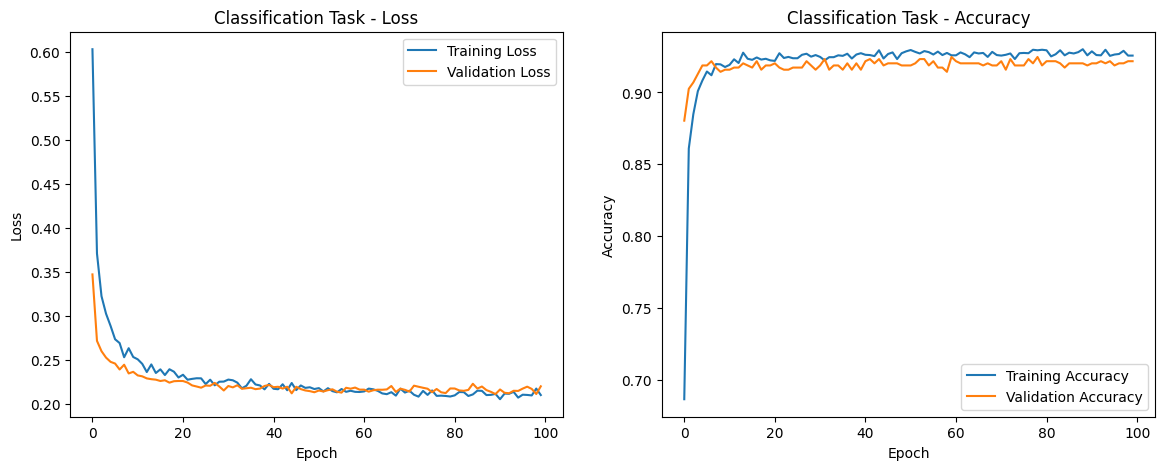



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1566 - precision: 0.9504 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


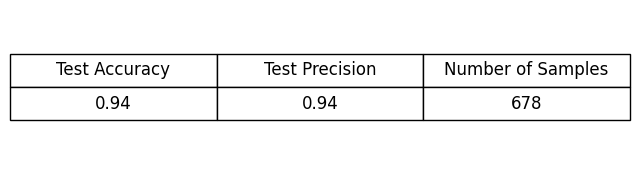

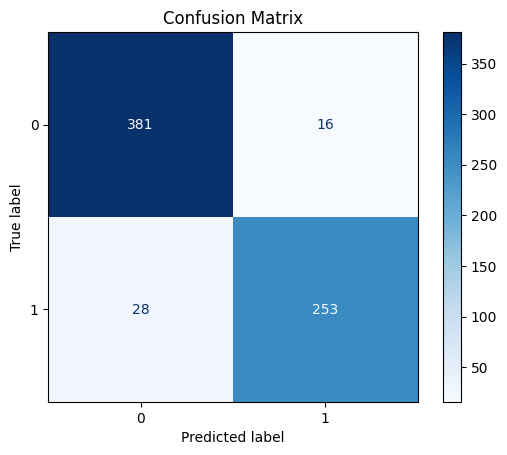

In [15]:
plt.figure(figsize=(14, 5)) # Set fig size

# Plot training and validation loss values over epochs
plt.subplot(1, 2, 1) # Divides fig into 1 x 2 grid (2 plots next to each other), and sets following fig as the first of the two
plt.plot(history.history['loss'], label='Training Loss') # history.history is a dictionary that stores loss and accuracy values for each epoch
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Classification Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training and validation accuracy values over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Task - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

print('\n')

# Evaluate the model on the test set and plot results
test_loss, test_accuracy, test_precision = class_model.evaluate(X_test_scaled, Y_test)
Y_test_pred = class_model.predict(X_test_scaled)
Y_test_pred_class = (Y_test_pred >= 0.5).astype(int)

# Plot the table 

plt.figure(figsize=(8, 2)) # Width and height
table_data = [['Test Accuracy', 'Test Precision', 'Number of Samples'], [f'{test_accuracy:.2f}', f'{test_precision:.2f}', f'{len(Y_test)}']] # 2D array with all the values
table = plt.table(cellText=table_data, loc='center', cellLoc='center')
table.scale(1, 2) 
table.auto_set_font_size(False) # Default size was too big, needed to reduce
table.set_fontsize(12)
plt.axis('off')  # Hide the axis

plt.show()

# Plot the confusion matrix

cm = confusion_matrix(Y_test, Y_test_pred_class) # Create a confusion matrix
confmatrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
confmatrix.plot(cmap = plt.cm.Blues) # Specifies colour map, uses blue shades to represent values
plt.title('Confusion Matrix')
plt.show()

Now lets build another neural network for the regression task.

As we did for the classification data, lets replace all missing values with the averages of their respective columns.

In [16]:
regression_data.replace(-200, np.nan, inplace = True)  
regression_data.fillna(regression_data.mean(), inplace = True) 

The goal is to predict the NOx(GT) values based on other air quality features, so lets first drop the 'NOx(GT)' and 'PT08.S3(NOx)' features from our shuffled dataset and set this to our X matrix. Our target (Y) vector will be the 'NOx(GT)' column.

Just as we did for the classification task, lets split this data up into a training, validation, and test set and then scale the X_train, X_val, and X_test sets.

We will leave out comments where the code is similar to code in the classification task.

In [17]:
X = regression_data.drop(columns = ['NOx(GT)','PT08.S3(NOx)'])
Y = regression_data['NOx(GT)']
print(X.shape)
print(Y.shape)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = 0.2) 
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.5) 
Y_val = Y_val.reset_index(drop = True) # Y_val is sampled randomly, so has random indices. We need to reset them so we can plot these values against the Y_val predictions later
reg_scaler = StandardScaler()

X_train_scaled = reg_scaler.fit_transform(X_train)
X_val_scaled = reg_scaler.transform(X_val)
X_test_scaled = reg_scaler.transform(X_test)

print(f'Training X shape: {X_train.shape}')
print(f'Training Y shape: {Y_train.shape}')
print(f'Testing X shape: {X_val.shape}')
print(f'Testing Y shape: {Y_val.shape}')
print(f'Testing X shape: {X_test.shape}')
print(f'Testing Y shape: {Y_test.shape}')

(6785, 11)
(6785,)
Training X shape: (5428, 11)
Training Y shape: (5428,)
Testing X shape: (678, 11)
Testing Y shape: (678,)
Testing X shape: (679, 11)
Testing Y shape: (679,)


Again, lets use a sequential model with 2 hidden layers, each of 20 neurons.

For the loss function, we will use the mean square error (mse), the most common loss function for regression tasks.

The reasoning behind model architecture, optimizers, etc is the same as for the classification task. Note that overfitting wasn't a problem in this case, so I didn't need to add in regularization or dropout layers.

Also note that Keras doesn't have a built-in metric for RMSE, so we will need to add it add a custom metric. We can create a custom function and then pass that in the metrics parameter.

In [18]:
reg_model = Sequential([
    Input(shape = (X_train_scaled.shape[1],)),
    Dense(20, activation = 'relu'),
    Dense(20, activation = 'relu'),
    Dense(1) # Output layer for regression. No need for an actiavtion function as the output can take any value unlike in classification
])

# Create the custom RMSE function
def RMSE(Y, Y_pred):
    RMSE = tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y))) # tf.square computes the square of the tensor elements, tf.reduce_mean computes the mean, and tf.sqrt compute the square root
    return RMSE

reg_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae', RMSE])

reg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 20)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681 (2.66 KB)

 Trainable params: 681 (2.66 KB)

 Non-trainable params: 0 (0.00 B)

Now lets train the model and observe the results.

In [19]:
history = reg_model.fit(X_train_scaled, Y_train, epochs = 100, validation_data = (X_val_scaled, Y_val))

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 99334.8125 - mae: 237.8499 - rmse: 310.9944 - val_loss: 87420.9609 - val_mae: 221.1141 - val_rmse: 300.3408
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 73921.5312 - mae: 196.2886 - rmse: 265.6284 - val_loss: 24883.9141 - val_mae: 116.0302 - val_rmse: 164.4062
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20023.6855 - mae: 100.6493 - rmse: 138.6175 - val_loss: 12905.7139 - val_mae: 80.7027 - val_rmse: 119.4407
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13760.4688 - mae: 82.3053 - rmse: 114.6023 - val_loss: 10223.7363 - val_mae: 70.8861 - val_rmse: 106.1053
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11587.3906 - mae: 73.3138 - rmse: 104.7514 - val_loss: 8754.1846 - val_mae: 64.7519 - val_rmse: 97.9518
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9468.1924 - mae: 66.3052 - rmse: 94.4731 - val_loss: 7814.9482 - val_mae: 60.8062 - val_rmse: 92.4198

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


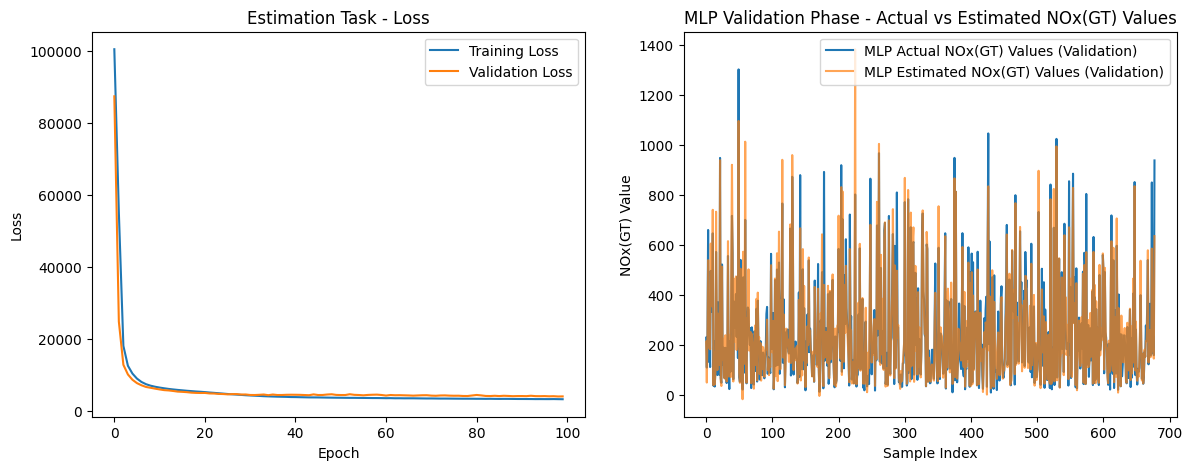

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3350.4092 - mae: 38.3164 - rmse: 55.6904 


Results on test set:


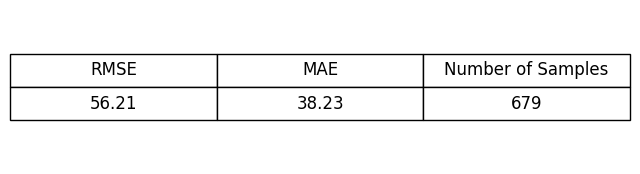

In [20]:
# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label ='Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.title('Estimation Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc ='upper right')


# Predict using the model and the validation X values, then plot validation estimates vs targets
Y_val_pred = reg_model.predict(X_val_scaled).flatten()

plt.subplot(1, 2, 2)
plt.plot(Y_val, label ='MLP Actual NOx(GT) Values (Validation)')
plt.plot(Y_val_pred, label='MLP Estimated NOx(GT) Values (Validation)', alpha = 0.7)
plt.title('MLP Validation Phase - Actual vs Estimated NOx(GT) Values')
plt.xlabel('Sample Index')
plt.ylabel('NOx(GT) Value')
plt.legend()
plt.show()

# Evaluate the model on the test set and plot results
test_loss, test_mae, test_rmse = reg_model.evaluate(X_test_scaled, Y_test)
num_samples = len(Y_test)

print('\n\nResults on test set:')

plt.figure(figsize=(8, 2)) # Width and height
table_data = [['RMSE', 'MAE', 'Number of Samples'], [f'{test_rmse:.2f}', f'{test_mae:.2f}', f'{num_samples}']] # 2D array with all the values
table = plt.table(cellText=table_data, loc='center', cellLoc='center')
table.scale(1, 2) 
table.auto_set_font_size(False) # Default size was too big, needed to reduce
table.set_fontsize(12)
plt.axis('off')  # Hide the axis

plt.show()

Now lets set up our code for the Week 6 tutorial, where we will be given a dataset and will need to make predictions with our models.

First, lets load in the dataset. We know the data will be in the same format as the dataset we have seen, so we can trim the first 2 columns so it will fit our model.

In [21]:
week6_filepath = 'Generalization Dataset.xlsx'
week6_data = pd.read_excel(week6_filepath)
week6_data = week6_data.iloc[:,2:]

Lets account for missing (-200) values just as we did in our previous dataset by setting values to NaN and then filling them with the mean of their columns. We know that this dataset doesn't have any missing values for the target values (CO(GT) in classification and NOx(GT) in regression), so we don't need to worry about dropping those rows - each sample has a target value that we can test our model against.

Then lets split up the data into our X values for the classification task and the regression task. For the classification task, we will also need to generate the labels again from the CO(GT) values and our CO_GT_Mean. Then we will need to scale the X values for both tasks using the same scaler that was used during training to ensure they are being scaled in the same way.

In [22]:
week6_data.replace(-200, np.nan, inplace = True)  # Replaces all -200 values with NaN values, and does so in place without needing to create a new table
week6_data.fillna(week6_data.mean(), inplace = True) # Replaces all NaN values with the mean of their respective columns, and does so in place without needing to create a new table

# Classification preprocessing
week6_class_X = week6_data.drop(columns = ['CO(GT)']) # Drop the CO(GT) column
week6_classification_labels = pd.DataFrame()
week6_classification_labels['Label'] = (week6_data['CO(GT)'] >= CO_GT_Mean).astype(int) # Generate classification labels
week6_class_X_scaled = class_scaler.transform(week6_class_X) # Scale X values using our class scaler
week6_class_Y = week6_classification_labels['Label']

# Regression preprocessing
week6_reg_X = week6_data.drop(columns = ['NOx(GT)','PT08.S3(NOx)']) # Drop both NOx columns
week6_reg_Y = week6_data['NOx(GT)']
week6_reg_X_scaled = reg_scaler.transform(week6_reg_X) # Scale X values using our reg scaler

Now lets first make our classification prediction.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.1478 - precision: 0.9617 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


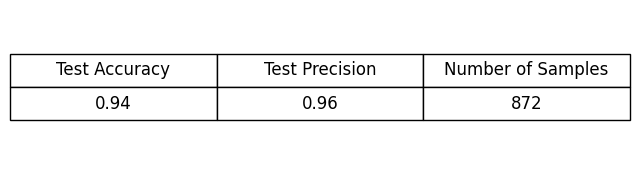

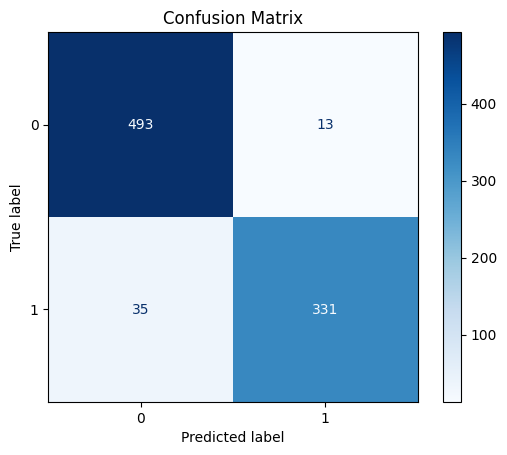

In [23]:
# Evaluate the model on the test set and plot results
week6_class_test_loss, week6_class_test_accuracy, week6_class_test_precision = class_model.evaluate(week6_class_X_scaled, week6_class_Y)
week6_class_Y_pred = class_model.predict(week6_class_X_scaled)
week6_class_Y_pred_class = (week6_class_Y_pred >= 0.5).astype(int)

# Plot the table 

plt.figure(figsize=(8, 2))
table_data = [['Test Accuracy', 'Test Precision', 'Number of Samples'], [f'{week6_class_test_accuracy:.2f}', f'{week6_class_test_precision:.2f}', f'{len(week6_class_Y)}']] # 2D array with all the values
table = plt.table(cellText=table_data, loc='center', cellLoc='center')
table.scale(1, 2) 
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.axis('off')
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(week6_class_Y, week6_class_Y_pred_class) # Create a confusion matrix
confmatrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
confmatrix.plot(cmap = plt.cm.Blues) # Specifies colour map, uses blue shades to represent values
plt.title('Confusion Matrix')
plt.show()

Lets now make our regression prediction.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2400.9468 - mae: 34.9123 - rmse: 44.8592 


Results on test set:


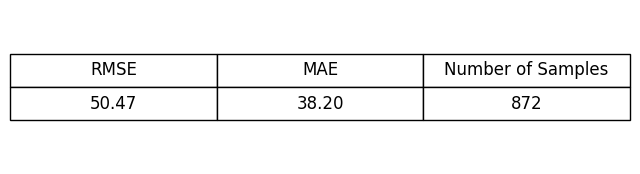

In [24]:
# Evaluate the model on the test set and plot results
week6_reg_test_loss, week6_reg_test_mae, week6_reg_test_rmse = reg_model.evaluate(week6_reg_X_scaled, week6_reg_Y)
num_samples = len(week6_reg_Y)

print('\n\nResults on test set:')

# Plot the table
plt.figure(figsize=(8, 2))
table_data = [['RMSE', 'MAE', 'Number of Samples'], [f'{week6_reg_test_rmse:.2f}', f'{week6_reg_test_mae:.2f}', f'{num_samples}']] # 2D array with all the values
table = plt.table(cellText=table_data, loc='center', cellLoc='center')
table.scale(1, 2) 
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.axis('off')
plt.show()